# Исследование о продажах компьютерных игр за 2016 год

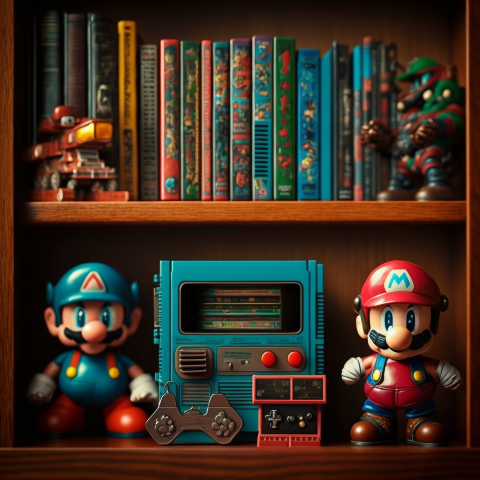

## Описание проекта

Отдел продаж интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры, заказал провести анализ продаж за 2016. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр.

## Задачи проекта

Выявить определяющие успешность игры закономерности и сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Спрогнозировать продажи на 2017 год по данным 2016 года.

### 1. Откроем файл и изучим данные

In [2]:
# загружаем необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import date

In [3]:
# загрузим файл и выведем первые 10 строк

try:
    df = pd.read_csv('C:/Users/Admin/Documents/Data_Analytic/Datasets/games.csv')
except:
    df = pd.read_csv('/datasets/games.csv')

    pd.set_option('display.max_columns', None)
df.to_csv('games.csv', index=False) 

df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В дата сете 16714 строк записей в которых значительная доля пропусков в оценках игр. В современом мире сложно представить игру без рейтинга и оценок пользователей, геймеры перед покупкой игры первым дело обращают внимание на эти показатели. Предположим пропуски связаны с тем, что на заре зарождения компьютерных игр оценки пользователей и критиков не проводились, либо не сохранялись. Пропуски сформированы по  механизму MNAR (Missing Not At Random), удалять пропуски не будем, там где необходимо можем просто исключить значения из расчетов.

Из каких данных состоит датасет:
* Name — название игры
*Platform — платформа
*Year_of_Release — год выпуска
*Genre — жанр игры
*NA_sales — продажи в Северной Америке (миллионы проданных копий)
*EU_sales — продажи в Европе (миллионы проданных копий)
*JP_sales — продажи в Японии (миллионы проданных копий)
*Other_sales — продажи в других странах (миллионы проданных копий)
*Critic_Score — оценка критиков (максимум 100)
*User_Score — оценка пользователей (максимум 10)
*Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [5]:
print('Начало периода:', df['Year_of_Release'].min())
print('Оцениваемый период:', df['Year_of_Release'].max()-df['Year_of_Release'].min())

Начало периода: 1980.0
Оцениваемый период: 36.0


### 2. Подготовим данные для исследований

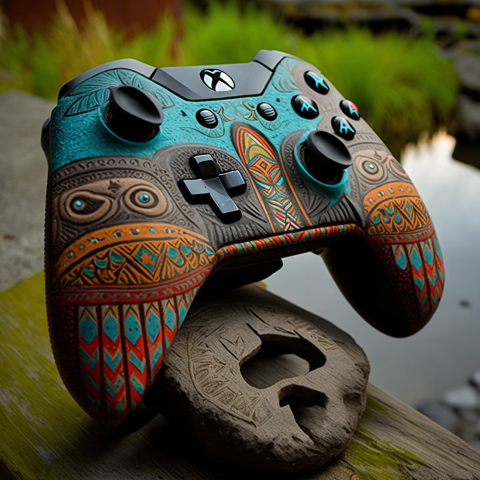

In [6]:
# заменим названия столбцов (приведем к нижнему регистру)

df.columns = df.columns.str.lower()

In [7]:
# посчитаем количество дубликатов

df.duplicated().sum()

0

In [8]:
# посчитаем количество пропусков в данных для каждого столбца

df.isna().sum().sort_values(ascending=False)

critic_score       8578
rating             6766
user_score         6701
year_of_release     269
name                  2
genre                 2
platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
dtype: int64

Половина всех пропусков находится в столбце **critic_score**, а также **user_score**. Пропуски заменим на нулевые значения, в будущем нам понадобятся сведения о продажах в разных регионах.

In [9]:
# заполним пропущенные значения в столбцах

df[['critic_score', 'user_score']] = df[['critic_score', 'user_score']].fillna(0)

# удалим остальные строки

df = df.dropna(subset=['year_of_release', 'name'])

In [10]:
# изучим уникальные значения рейтингов

df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

В данных рейтинга присутствуют записи **К-А**(Kids to Adults), по классификации ESRB это устаревший рейтинг применяемый до 1998 года и в дальнейшем переименован в **Е**. Рейтинг **RP**(Rating Pending) означает что рейтинг не присвоен/ожидается, можем пропуски заменить на **RP**.

In [11]:
# обработаем зачения рейтингов по условиям

df['rating'] = df['rating'].replace('K-A', 'E').fillna('RP')

In [12]:
# в столбце year_of_release изменим тип данных на int (целое число)

df['year_of_release'] = df['year_of_release'].astype('int32')

# данные в столбце critic_score переведем в формат оценок от 0-10, для этого разделим все значения на 10

df['critic_score'] = df['critic_score'] / 10

# в столбце user-score присутствуют записи tbd, сокращение от "значение пока не определено", замениним на ноль

df['user_score'] = df['user_score'].replace('tbd', '0')

# тип данных в столбце user-score изменим на float (Числа с плавающей точкой)

df['user_score'] = df['user_score'].astype('float32')

In [13]:
# проверим наличие пропусков

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [14]:
# добавим столбец о всех продажах

df['all_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [15]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,7.6,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,8.2,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,8.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,RP,31.38


In [16]:
# на каких платформах выпускались игры

df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

**Выводы:** 

* привели названия столбцов к нижнему регистру
*обработали пропуски, заменили пропуски исправили значения в рейтингах
*типы данных были изменены там где необходимо
*добавили новый столбец с данным об общих продажах

### 3. Исследовательский анализ данных

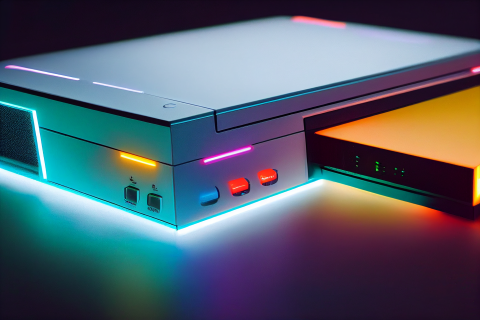

In [17]:
# самые продаваемые игры за период

df.groupby('name')['all_sales'].agg(['count', 'sum']).sort_values(by='sum', ascending=False).head(10)


,count,sum
name,,
Wii Sports,1,82.54
Grand Theft Auto V,5,56.58
Super Mario Bros.,2,45.31
Tetris,2,35.84
Mario Kart Wii,1,35.52
Wii Sports Resort,1,32.77
Pokemon Red/Pokemon Blue,1,31.38
Call of Duty: Modern Warfare 3,4,30.60
New Super Mario Bros.,1,29.80


Благодаря современным инновациям **Сигэру Миямото** удалось покорить сердца миллионов игроков по всему миру, выпустив народный игровой симулятор **Wii Sports** в 2006 году. 

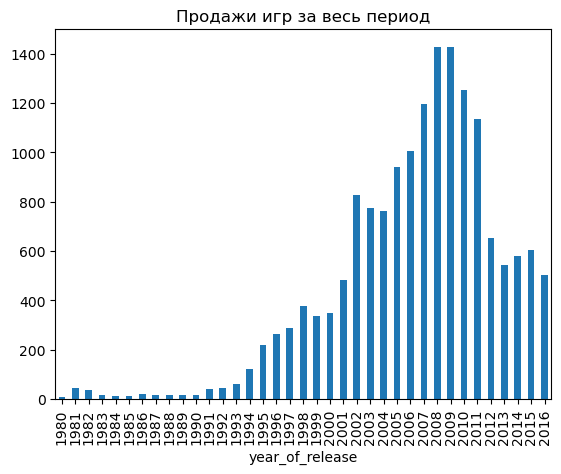

In [18]:
# посмотрим, сколько игр выпускалось в разные годы

df.groupby('year_of_release')['name'].count().plot(kind='bar')
plt.title('Продажи игр за весь период');

На графике можно увидеть как развивалась индустрия компьютерных игр. В этом периоде можно выделить 4 этапа:
* с 1980 по 1993 зарождение индустрии совместно с развитием компьютерных технологий
* с 1994 по 2001 появился первый интерес, повсеместное внедрение компьютерной техники и высоких технологий
* с 2002 по 2011 бум развития игровой индустрии, привлечение капитала, популяриция игр
* с 2012 по 2016 произошло насыщение рынка, продажи выровнялись 

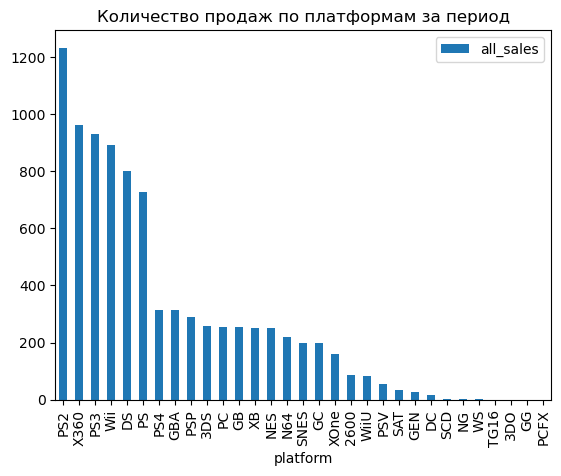

In [19]:
# посмотрим, как менялись продажи по платформам

df.groupby(['platform']).agg({'all_sales': 'sum'}).sort_values(by='all_sales',ascending=False).plot.bar(stacked=True)
plt.title('Количество продаж по платформам за период');

Первые места по продажам разделили между собой производители из США и Японии:
* PS2 - PlayStation 2 выпущенная компанией Sony в марте 2000
*X360 - Xbox 360 игровая приставка компании Microsoft выпущена в ноябре 2005, прямой конкурент PlayStation 2
*PS3 - усовершенствованная версия PlayStation 2 была выпущена в ноябре 2006
*Wii - игровая приставка 7-го поколения фирмы Nintendo
*DS - карманная игровая консоль компании Nintendo выпущенная в ноябре 2004

In [20]:
# выделим топ-5 платформ и посмотрим как менялись продажи

top_platform = (df.pivot_table(index='platform', values='all_sales', aggfunc='sum')
                .sort_values(by='all_sales', ascending=False)
                )

PS2


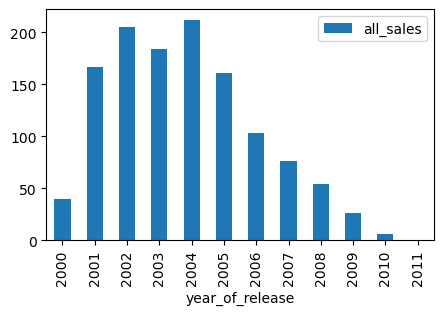

X360


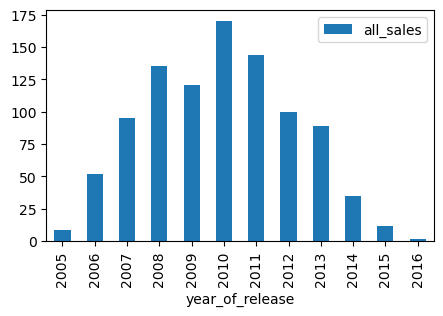

PS3


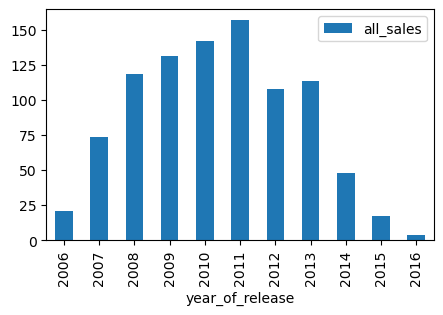

Wii


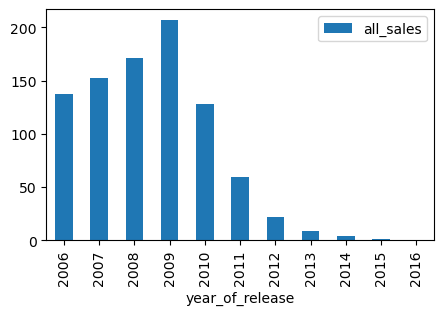

DS


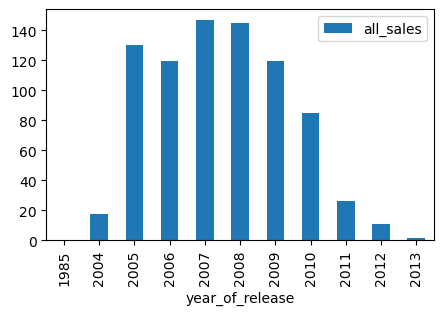

In [21]:
# с помощью цикла построим графики продаж топ-5 платформ за весь период

for platform in top_platform.index[:5]:
    print(platform)
    (df.query('platform == @platform')
    .pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')
    .plot(kind='bar', figsize=(5, 3))
    )
    plt.show()

Как видно из графиков средний срок жизни платформы - **10 лет**, на смену старым поколениям, приходят новые технологичные платформы.

Рынок продаж поделили между собой разработчики от Sony и Miscosoft. На графике видно как рост продаж и активный интерес к компьютерным играм начался в 2000 году и пережил свой пик в 2008-2009 года и дальше продажи пошли на спад. Больше всех смогли продать продали игр разработчки на платформах Sony Play Station 2, Microsoft XBOX360, Sony Play Station 3, Microsoft Wii и мобильное устройство Nintendo DS.

Рассмотрев динамику топ-5 лидеров продаж определили, что игры на этих платформах были актуальны в период с 2000 по 2012 и в настоящее время продажи находятся на минимальном уровне. Сделаем предположение о том, что на смену старым платформам пришли новые более мощные системы, где еще не так много вышло новых игр и уровень продаж не вырос до уровня продаж предыдущих поколений. Поэтому дальнейшая задача исследования рассмотреть между какими платформами распределяются продажи игр.

**Еще раз обратимся к графику о продажах за весь период. Всеобщий интерес к компьютерным играм наблюдался в период с 2005 по 2011 год, а начиная с 2012 продажи выровнялись и без значительных колебаний имели устойчивю динамику до 2016 года, поэтому определим данный период как АКТУАЛЬНЫЙ**

In [22]:
# оставим в датафрейме только данные за актуальный период

actual_df = df.query('2012 <= year_of_release <= 2016').reset_index(drop=True)

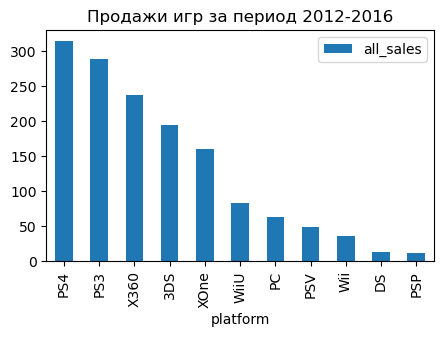

In [23]:
# построим график всех продаж за актуальный период

(
    actual_df
        .pivot_table(index=['platform'], values='all_sales', aggfunc='sum')
        .sort_values(by='all_sales', ascending=False)
        .plot(kind='bar', figsize=(5, 3))
);
plt.title('Продажи игр за период 2012-2016');

В актуальном периоде с 2012 по 2016 год лидерство по прежнему удерживает платформа от компании **Sony**. В топ-5 лидеров входит платформа X360 от **Microsoft** и новое поколение мобильных игровых устройств 3DS от компании **Nintendo** выпущенная в 2011 году.

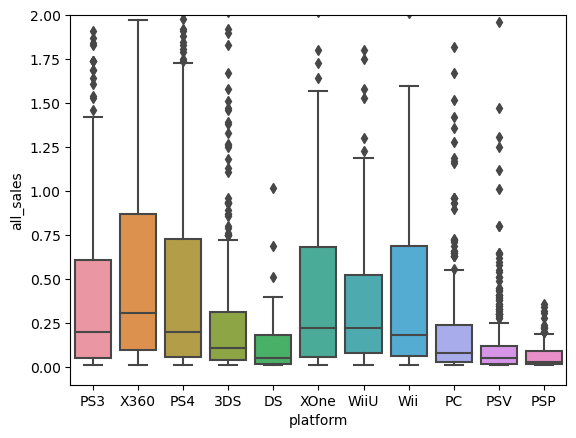

In [24]:
# построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

sns.boxplot(data=actual_df, x='platform', y='all_sales')
plt.ylim(-0.1, 2);

На графике продаж игр за период с 2012-2016 у топовых платформ размах продаж в среднем находится в диапазоне 100-700 тыс. копий, а медианное значение по всем платформам составляет примерно 200 тыс копий. Также обращают на себя внимания "хвосты" пределов нормальных значений, это связано с удачными проектами.

Корреляция продаж с оценкой критиков:  0.4058948014583661


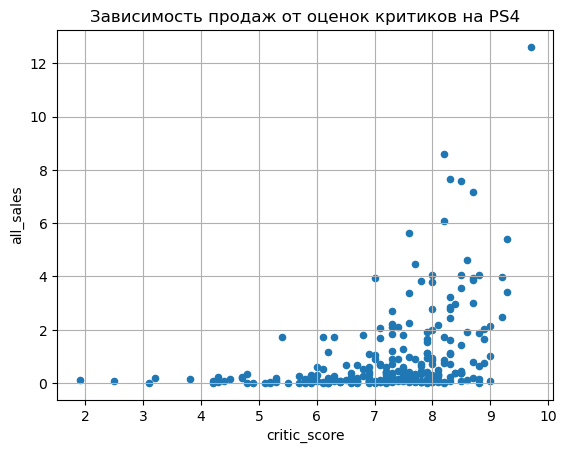

In [25]:
# рассмотрим зависимость продаж от оценки критиков на примере популярной платформы PS4

ps4_df = actual_df.query('platform == "PS4" & (critic_score != 0 & user_score != 0)')

ps4_df.plot(x='critic_score', y='all_sales', kind='scatter', grid=True)
plt.title('Зависимость продаж от оценок критиков на PS4');

print('Корреляция продаж с оценкой критиков: ', ps4_df['critic_score'].corr(ps4_df['all_sales']))

Корреляция продаж с оценкой пользователей:  -0.03362497596528878


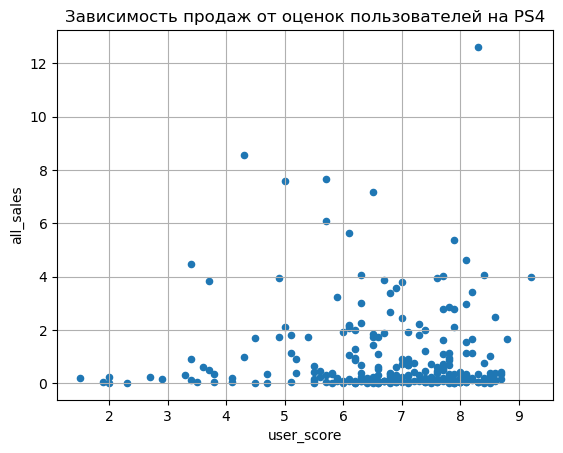

In [26]:
# рассмотрим зависимость продаж от оценки пользователей на примере популярной платформы PS4

ps4_df.plot(x='user_score', y='all_sales', kind='scatter', grid=True)
plt.title('Зависимость продаж от оценок пользователей на PS4');

print('Корреляция продаж с оценкой пользователей: ', ps4_df['user_score'].corr(ps4_df['all_sales']))

In [27]:
# посмотрим корреляцию как оценки влияют на продажи

ps4_df[['critic_score', 'user_score', 'all_sales']].corr()

,critic_score,user_score,all_sales
critic_score,1.000000,0.557654,0.405895
user_score,0.557654,1.000000,-0.033625
all_sales,0.405895,-0.033625,1.000000


Вывод: на примере популярной платформы PS4 рассмотрели как вляют оценки игр на количество продаж. Выявили среднюю взаимосвязь оценок критиков и пользователей, но влияние на продажи больше оказывают оценки критиков а оценки пользователей не вляют, вероятно критики более объективны.

X360


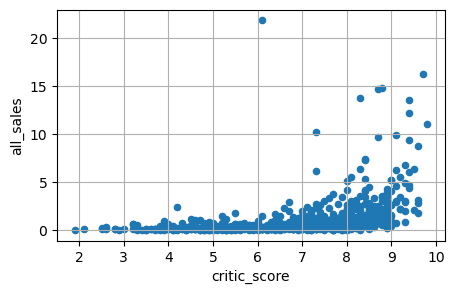

PS3


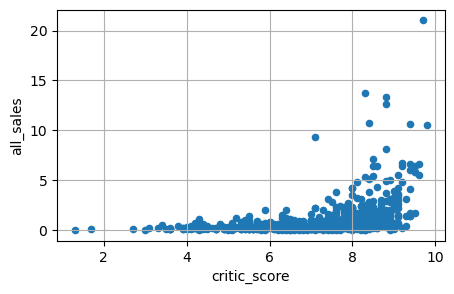

Wii


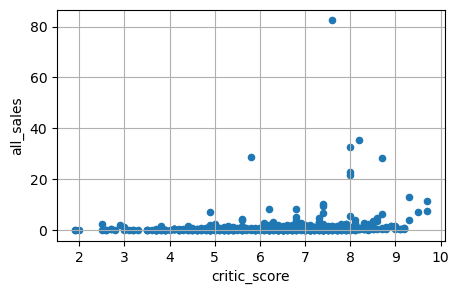

DS


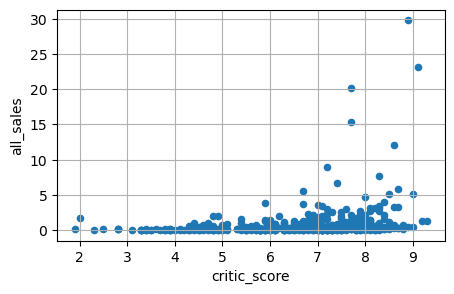

In [28]:
# с помощью цикла построим диаграммы оценок и продаж остальных топ-4 платформ

for platform in top_platform.index[1:5]:
    print(platform)
    (df.query('platform == @platform & (critic_score != 0 & user_score != 0)')
    .plot(x='critic_score', y='all_sales', kind='scatter', grid=True, figsize=(5, 3))
    )
    plt.show()

Для остальных платформ характерно также наличие средней зависимости уровня продаж от оценки критиков. Наблюдается умеренная взаимосвязь, чем выше оценка критиков тем выше продажи.

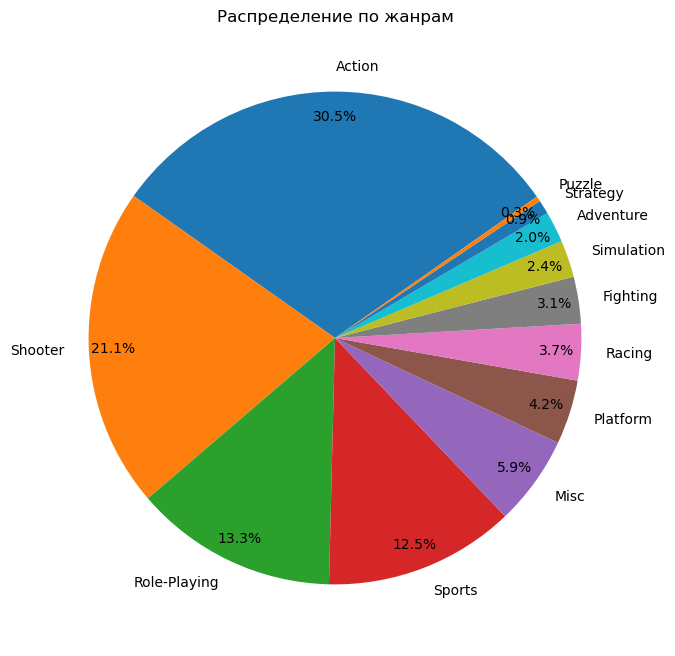

In [50]:
# посмотрим как уровень продаж зависит от жанра

(
actual_df.pivot_table(index='genre', values='all_sales', aggfunc='sum')
    .sort_values(by='all_sales', ascending=False)
    .plot(kind='pie', subplots=True, pctdistance=0.90,\
          autopct='%1.1f%%', legend=False, startangle=35, figsize=(8,8))
)
plt.title('Распределение по жанрам')
plt.axis('off');

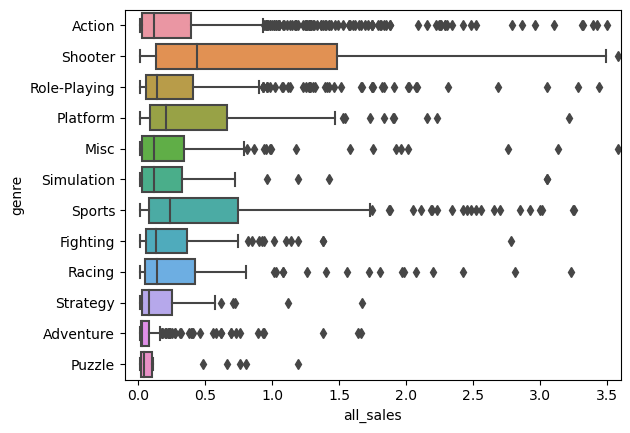

In [48]:
# построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

sns.boxplot(data=actual_df, x='all_sales', y='genre')
plt.xlim(-0.1,3.6);

Круговая диаграмма наглядно демонстрирует, что среди трети игроков по всему миру лидирует жанр **Action**, на втором месте в библиотеке у игроманов находятся игры жанра **"Shooters"** и третье место делят между собой **спортивные** и игры жанра **Role-Playing**. С помощью диаграмм разброса рассмотрели какие жанры в среднем имеют больше продаж, с точки зрения прибыльности лидирует жанр Shooter, Sport и замыкает тройку жанр Platform. Для жанра Action характерна особенность - хоть игры в данной категории самые популярные, лучшие продажи демонстрируют отдельные проекты, об этом свидетельствует большое количество выбросов на диаграмме разброса.

### 4. Составим портрет пользователя каждого региона

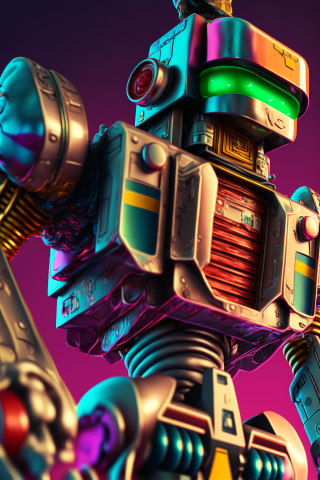

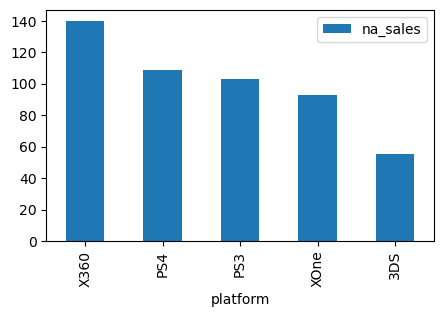

In [31]:
# посмотрим на самые популярные платформы в NA-регионе

actual_df_pivot = (actual_df.pivot_table(index='platform', values='na_sales', aggfunc='sum')
            .sort_values(by='na_sales', ascending=False)
            .head(5)
            .plot(kind='bar', figsize=(5, 3))
           )

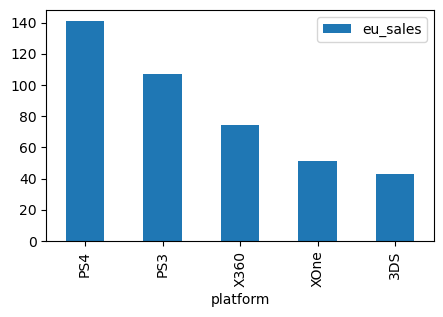

In [32]:
# посмотрим на самые популярные платформы в EU-регионе

actual_df_pivot = (actual_df.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
            .sort_values(by='eu_sales', ascending=False)
            .head(5)
            .plot(kind='bar', figsize=(5, 3))
           )

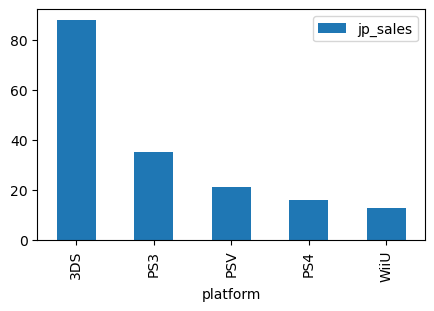

In [33]:
# посмотрим на самые популярные платформы в JP-регионе

actual_df_pivot = (actual_df.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
            .sort_values(by='jp_sales', ascending=False)
            .head(5)
            .plot(kind='bar', figsize=(5, 3))
           )

В каждом **регионе** заметны свои особенности, в Северо-Американском регионе игроки предпочитают собственного разрабочика **Microsoft** - приставку Xbox360, в Европе пользователи играют на **Sony Playstation 4** и **Sony Playstation 3**. Японские игроки менее требовательны и предпочитают мобильные игровые устройства - **Nintendo 3DS**

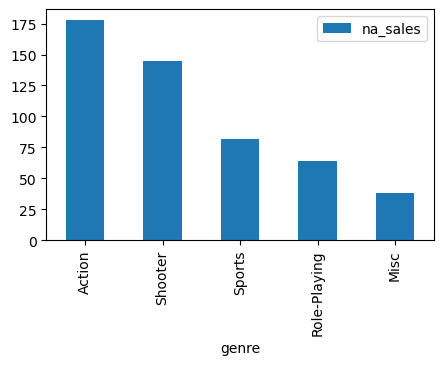

In [34]:
# посмотрим на самые популярные жанры в NA-регионе

actual_df_pivot = (actual_df.pivot_table(index='genre', values='na_sales', aggfunc='sum')
            .sort_values(by='na_sales', ascending=False)
            .head(5)
            .plot(kind='bar', figsize=(5, 3))
           )

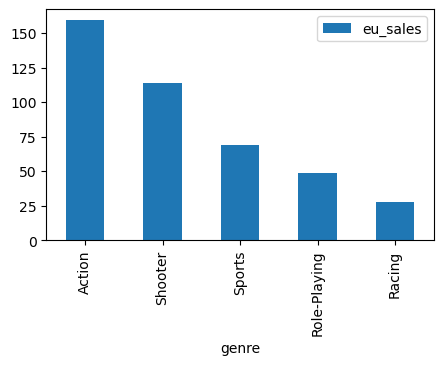

In [35]:
# посмотрим на самые популярные жанры в EU-регионе

actual_df_pivot = (actual_df.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
            .sort_values(by='eu_sales', ascending=False)
            .head(5)
            .plot(kind='bar', figsize=(5, 3))
           )

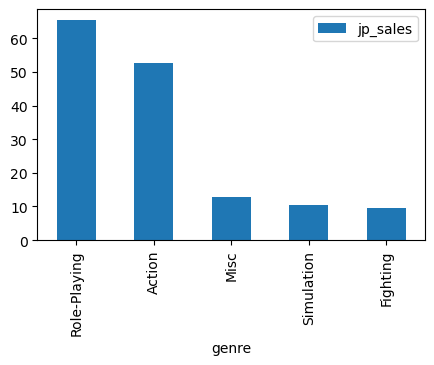

In [36]:
# посмотрим на самые популярные жанры в JP-регионе

actual_df_pivot = (actual_df.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
            .sort_values(by='jp_sales', ascending=False)
            .head(5)
            .plot(kind='bar', figsize=(5, 3))
           )

Как было видно ранее на круговой диаграмме, пользователи игровых платформ увлекаются играми с жанром **Action**, японские пользователи в этот раз меньше хотят насилия в жанре shooters и предпочитают **ролевые игры**.

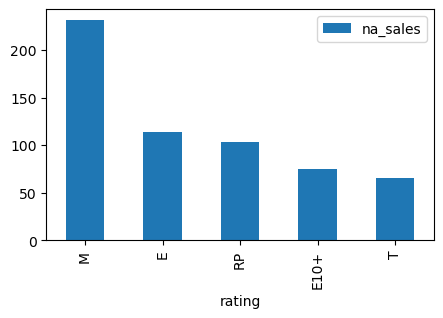

In [37]:
# посмотрим игры с каким рейтингом самые популярные в NA-регионе

actual_df_pivot = (actual_df.pivot_table(index='rating', values='na_sales', aggfunc='sum')
            .sort_values(by='na_sales', ascending=False)
            .head(5)
            .plot(kind='bar', figsize=(5, 3))
           )

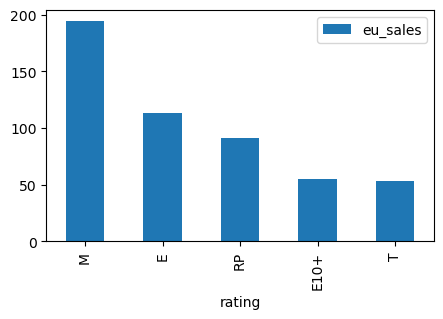

In [38]:
# посмотрим игры с каким рейтингом самые популярные в EU-регионе

actual_df_pivot = (actual_df.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
            .sort_values(by='eu_sales', ascending=False)
            .head(5)
            .plot(kind='bar', figsize=(5, 3))
           )

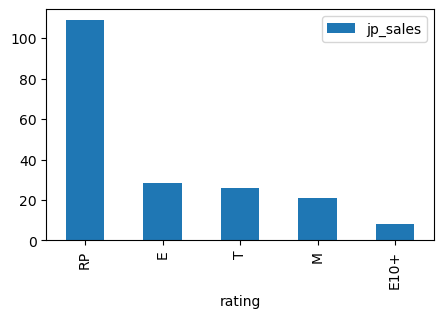

In [39]:
# посмотрим игры с каким рейтингом самые популярные в JP-регионе

actual_df_pivot = (actual_df.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
            .sort_values(by='jp_sales', ascending=False)
            .head(5)
            .plot(kind='bar', figsize=(5, 3))
           )

На графике рейтингов в японском регионе большинство игр выпускается с рейтингом RP, то есть рейтинг не определен. Вероятно эта особенность связана с тем, что пользователи выбирают платформы собственной страны и разработчики выпускают игры для внутреннего пользования, поэтому рейтинг агенства ESRB не присваивается. В остальных регионах лидерами продаж игры с рейтингом M - для взрослых (содержащие сцены насилия, ненормативная лексика)

### 5. Проверка гипотез

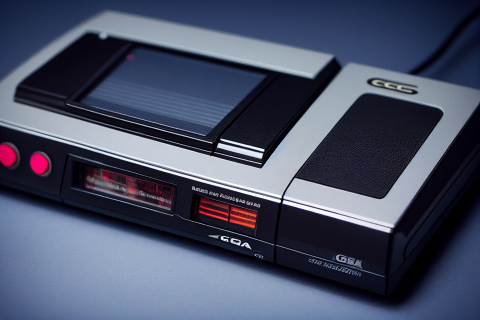

Проверим различия пользовательских рейтингов платформ **Xbox One** и **PC**. Построем нулевую гипотезу (Н0) - рейтинги у платформ одинаковые, альтернативна гипотеза (Н1) - рейтинги различаются. Применим метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Передадим методу массивы, содержащие выборки и используем уровень статистической значимости 95%.

In [40]:
# подготовим датасет, удалим нулевые значения пользовательских оценок

new_actual_df = actual_df[actual_df['user_score'] != 0]

# создадим массивы, содержащие выборки

array1 = new_actual_df.loc[new_actual_df['platform'] == 'XOne', ['user_score']]
array2 = new_actual_df.loc[new_actual_df['platform'] == 'PC', ['user_score']]

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    array1, 
    array2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: [0.55350805]
Не получилось отвергнуть нулевую гипотезу


In [41]:
# посчитаем среднее значение рейтингов платформ

xbox_score = actual_df.query('platform == "XOne" and user_score > 0')
print('Средняя оценка на платформе XOne:', xbox_score['user_score'].mean())
pc_score = actual_df.query('platform == "PC" and user_score > 0')
print('Средняя оценка на платформе PC:', pc_score['user_score'].mean())

Средняя оценка на платформе XOne: 6.52142857142857
Средняя оценка на платформе PC: 6.428640776699027


**Вывод:** Значение p-value показывает: вероятность случайно получить различие в рейтингах равно почти 55%, вероятность слишком большая чтобы делать вывод о значимом различии рейтингов между платформами. Действительно мультиплатформенные игры пользователи одинаково оценивают и разница в оценках практически отсутствует.

Проверим различия пользовательских рейтингов по жанрам **Action** и **Sport**. Построем нулевую гипотезу (Н0) - рейтинги у жанров одинаковые, альтернативна гипотеза (Н1) - различаются. Применим метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Передадим методу массивы, содержащие выборки и используем уровень статистической значимости 95%.

In [42]:
# создадим массивы, содержащие выборки

array1 = new_actual_df.loc[new_actual_df['genre'] == 'Action', ['user_score']]
array2 = new_actual_df.loc[new_actual_df['genre'] == 'Sports', ['user_score']]

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    array1, 
    array2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: [3.71630895e-26]
Отвергаем нулевую гипотезу


In [43]:
# посчитаем среднюю оценку жанра Action

xbox_score = actual_df.query('genre == "Action" and user_score > 0')
print('Средняя оценка Action:', xbox_score['user_score'].mean())

# посчитаем среднюю оценку жанра Sports

pc_score = actual_df.query('genre == "Sports" and user_score > 0')
print('Средняя оценка Sports:', pc_score['user_score'].mean())

Средняя оценка Action: 6.825047801147237
Средняя оценка Sports: 5.455897435897437


**Вывод:** Подтвердилась альтернативная гипотеза, игроки по разному оценивают игры из разных жанров. Вероятно в домашней коллекции среднестатистического игрока будет больше игр жанра **Action** чем **Sport**.

### 6. Общий вывод

Изучили как развивалась индустрия компьтерных игр за период с 1980 по 2016 год и выделили четыре этапа: **первый** этап с 1980 по 1993 зарождение индустрии совместно с развитием компьютерных технологий. **Второй этап** с 1994 по 2001 появился первый интерес, повсеместное внедрение компьютерной техники и высоких технологий. **Третий этап** с 2002 по 2011 бум развития игровой индустрии, привлечение капитала, популяриция игр. **Четвертый этап** с 2012 по 2016 произошло насыщение рынка, продажи выровнялись.

Был проведен анализ, как распределялись продажи за период с 1980 по 2016 в разрезе платфомы, определили, что первые места по продажам разделили между собой производители из США и Японии:
* PS2 - PlayStation 2 выпущенная компанией Sony в марте 2000
* X360 - Xbox 360 игровая приставка компании Microsoft выпущена в ноябре 2005, прямой конкурент PlayStation 2
* PS3 - усовершенствованная версия PlayStation 2 была выпущена в ноябре 2006
* Wii - игровая приставка 7-го поколения фирмы Nintendo
* DS - карманная игровая консоль компании Nintendo выпущенная в ноябре 2004

Чтобы убрать из анализа устаревшие данных о платформах, был определен **период для анализа** с 2012 по 2016, в котором можно проследить формирование новых трендов в развитии игровой индустрии. В этом периоде выделили основных лидеров рынка по производству игр:
* PS4 - новое поколение PlayStation выпущенное компанией Sony в ноябре 2013
* PS3 - устаревшая, но не потерявшая свою актуальность платформа
* X360 - также устаревшая но еще актуальная платформа, к этому времени уже появилось следующее поколение Xbox One, но продажи пока не перебили уровень X360
* DS3 - новая портативная игровая система производства Nintendo, выпущенная в ноябре 2011

Провели анализ топ-5 платформ за период 2012-2016 гг. - размах продаж в диапазоне **100-700 тыс. копий**, а медианное значение по всем платформам составляет примерно **200 тыс копий**. 

Рассмотрели как вляют оценки игр на количество продаж. Выявили среднюю взаимосвязь оценок критиков и пользователей, но влияние на продажи больше оказывают оценки критиков а оценки пользователей не вляют, вероятно критики более объективны. Также определили, что треть игроков по всему миру предпочитают игры в жанре **Action**, на втором месте в библиотеке у игроманов находятся игры жанра **"Shooters"** и третье место делят между собой **спортивные** и игры жанра **Role-Playing**.

Был составлен портрет среднестатистичекого пользователя в каждом регионе:
* в **северо-американском** регионе продажи игр делят между собой следующие платформы: X360, PS4 и PS3. Следует обратить внимание на платформу Xone, которая пришедшла на смену X360 и хотя продажи по ней не превысили уровень предшественницы, в 2017 году продажи могут значительно вырасти. Пользователи отдают предпочтение играм в жанрах "Action", "Shooters" и "Sports" игры в основном не предназначены для детей, так как содержат сцены насилия и ненормативную лексику.
* в **еропейском регионе** лидерство по продажам принадлежит платформам от Sony - PS4 и PS3, за ними платформы от Microsoft - X360 и XOne. Предпочтения схожи со вкусами пользователей из северо-американского региона, те же жанры с возрастными ограничениями
* в **японском** регионе с отрывом по продажам лидирует мобильная игровая платформа DS3 от компании Nintendo, PS3 и PSV - мобильная игровая платформа от Sony, конкурент DS3. Пользователи проводят свободное время в играх жанра Role-Playing.

Проверили следующие гипотезы:
* средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**. Получили значение p-value [0.55], отвергнуть гипотезу (Н0) не удалось - пользовательские рейтинги платформ одинаковые
* средние пользовательские рейтинги жанров Action и Sports **разные**. Получили значение p-value [3.71], подтвердилась альтернативная гипотеза (Н1) - игроки по разному оценивают игры из разных жанров.

На 2017 год отделу продаж интернет-магазина «Стримчик» следует планировать продажи на платформах PS4, PS3, X360 и новом поколении XOne, в жанрах Action, Shooters и Sports с возрастными ограничениями - для северо-американского и европейского регионов. Для японского региона продажи на мобильных устройствах DS3, PSV в жанрах Role-Playing и Action.

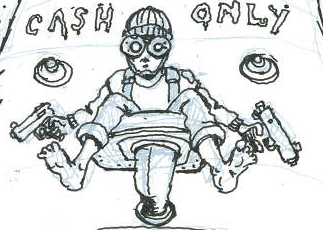

*<i>изображения созданы Midjourney</i>